In [1]:
import os
import re
import tempfile
import time

import numpy as np
import pvporcupine
import pyttsx3
import scipy.io.wavfile
import sounddevice as sd
import webrtcvad
import whisper
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage, trim_messages
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.chat import MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import MessagesState, StateGraph
from pvrecorder import PvRecorder
from pydantic import BaseModel, SecretStr, constr
from pydantic_settings import BaseSettings, SettingsConfigDict

/Users/hankehly/Projects/PALM-9000/.venv/lib/python3.12/site-packages/webrtcvad.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Define Constants

In [2]:
for i, device in enumerate(PvRecorder.get_available_devices()):
    print("Device %d: %s" % (i, device))

Device 0: NHK訪問営業部2 Microphone
Device 1: MacBook Pro Microphone
Device 2: Microsoft Teams Audio


In [3]:
whisper.available_models()

['tiny.en',
 'tiny',
 'base.en',
 'base',
 'small.en',
 'small',
 'medium.en',
 'medium',
 'large-v1',
 'large-v2',
 'large-v3',
 'large',
 'large-v3-turbo',
 'turbo']

In [4]:
pvporcupine.KEYWORDS

{'alexa',
 'americano',
 'blueberry',
 'bumblebee',
 'computer',
 'grapefruit',
 'grasshopper',
 'hey barista',
 'hey google',
 'hey siri',
 'jarvis',
 'ok google',
 'pico clock',
 'picovoice',
 'porcupine',
 'terminator'}

In [5]:
engine = pyttsx3.init()
voices = engine.getProperty("voices")
for i, voice in enumerate(voices):
    print(f"{i}: {voice.name} ({voice.languages[0]}) - {voice.id}")
    # if voice.languages[0] == "ja_JP":
    #     engine.setProperty("voice", voice.id)
    #     engine.say("こんにちは、私はPALM-9000です。")
    #     engine.runAndWait()
    # if voice.languages[0][:2] == "en":
    #     engine.setProperty("voice", voice.id)
    #     engine.say("Hello, I am PALM-9000.")
    #     engine.runAndWait()

0: Albert (en_US) - com.apple.speech.synthesis.voice.Albert
1: Alice (it_IT) - com.apple.voice.compact.it-IT.Alice
2: Alva (sv_SE) - com.apple.voice.compact.sv-SE.Alva
3: Amélie (fr_CA) - com.apple.voice.compact.fr-CA.Amelie
4: Amira (ms_MY) - com.apple.voice.compact.ms-MY.Amira
5: Anna (de_DE) - com.apple.voice.compact.de-DE.Anna
6: Bad News (en_US) - com.apple.speech.synthesis.voice.BadNews
7: Bahh (en_US) - com.apple.speech.synthesis.voice.Bahh
8: Bells (en_US) - com.apple.speech.synthesis.voice.Bells
9: Boing (en_US) - com.apple.speech.synthesis.voice.Boing
10: Bubbles (en_US) - com.apple.speech.synthesis.voice.Bubbles
11: Carmit (he_IL) - com.apple.voice.compact.he-IL.Carmit
12: Cellos (en_US) - com.apple.speech.synthesis.voice.Cellos
13: Damayanti (id_ID) - com.apple.voice.compact.id-ID.Damayanti
14: Daniel (en_GB) - com.apple.voice.compact.en-GB.Daniel
15: Daria (bg_BG) - com.apple.voice.compact.bg-BG.Daria
16: Wobble (en_US) - com.apple.speech.synthesis.voice.Deranged
17: Eddy 

In [ ]:
class Porcupine(BaseModel):
    access_key: SecretStr | None = None
    keywords: list[str] = ["computer"]


class Whisper(BaseModel):
    model: str = "base"


class Audio(BaseModel):
    input_device: int = 1
    sample_rate: int = 16000
    frame_duration_ms: int = 30
    frame_size: int = 480  # SAMPLE_RATE * FRAME_DURATION_MS // 1000
    silence_timeout: float = 1.5  # seconds of silence to trigger stop
    vad_mode: int = 3  # 0-3: 0 is least aggressive about filtering out non-speech
    preferred_voices: dict[str, str] = {
        "en": "com.apple.voice.compact.en-GB.Daniel",
        "ja": "com.apple.voice.compact.ja-JP.Kyoko",
    }


class Google(BaseModel):
    api_key: SecretStr | None = None


class Settings(BaseSettings):
    porcupine: Porcupine = Porcupine()
    whisper: Whisper = Whisper()
    google: Google = Google()
    audio: Audio = Audio()

    model_config = SettingsConfigDict(env_file=".env", env_nested_delimiter="__")


settings = Settings()

# Define Functions

### 1. Wake Word Detection

In [7]:
def wait_for_wake_word():
    """
    Waits for the wake word "computer" using Porcupine.
    This function blocks until the wake word is detected.
    """
    porcupine = pvporcupine.create(
        access_key=settings.porcupine.access_key.get_secret_value(),
        keywords=settings.porcupine.keywords,
    )
    recorder = PvRecorder(
        frame_length=porcupine.frame_length,
        device_index=settings.audio.input_device,
    )
    recorder.start()
    try:
        while True:
            pcm = recorder.read()
            result = porcupine.process(pcm)
            if result >= 0:
                print(f"Detected {settings.porcupine.keywords[result]}")
                recorder.delete()
                porcupine.delete()
                return True
    except KeyboardInterrupt:
        print("Stopping ...")
        recorder.delete()
        porcupine.delete()
        return False

### 2. Voice Activity Detection

In [8]:
def record_audio_with_vad() -> bytes:
    """
    Records audio using a voice activity detector (VAD).
    This function will start recording when speech is detected and stop when silence is detected for a specified timeout.
    It returns the recorded audio as bytes.
    """
    vad = webrtcvad.Vad(settings.audio.vad_mode)

    recording = False
    silence_start = None

    stream = sd.InputStream(
        samplerate=settings.audio.sample_rate,
        channels=1,
        dtype="int16",
        blocksize=settings.audio.frame_size,
        device=settings.audio.input_device,
    )
    stream.start()

    audio_data = []

    try:
        while True:
            block, _ = stream.read(settings.audio.frame_size)
            samples = block[:, 0].tobytes()

            is_speech = vad.is_speech(samples, settings.audio.sample_rate)

            if is_speech:
                if not recording:
                    print("🧠 Detected speech. Recording...")
                    recording = True
                silence_start = None
                audio_data.append(samples)
            elif recording:
                if silence_start is None:
                    silence_start = time.time()
                elif time.time() - silence_start > settings.audio.silence_timeout:
                    print("🤫 Silence detected. Stopping recording.")
                    break

    finally:
        stream.stop()

    return b"".join(audio_data)

### 3. Audio Transcription

In [9]:
class TranscribeAudioReturnValue(BaseModel):
    text: constr(strip_whitespace=True)
    language: str


whisper_model = whisper.load_model("base")


def transcribe_audio(audio_bytes: bytes) -> TranscribeAudioReturnValue:
    """
    Transcribe audio bytes using Whisper.
    """
    audio_array = np.frombuffer(audio_bytes, dtype=np.int16)
    with tempfile.NamedTemporaryFile(suffix=".wav") as tmpfile:
        scipy.io.wavfile.write(tmpfile.name, settings.audio.sample_rate, audio_array)
        decode_options = {"fp16": False}  # disable fp16 for CPU compatibility
        result = whisper_model.transcribe(tmpfile.name, **decode_options)
        return TranscribeAudioReturnValue(
            text=result["text"], language=result["language"]
        )

### 4. LLM

In [ ]:
# llm = HuggingFaceEndpoint(repo_id="deepseek-ai/DeepSeek-R1", task="text-generation")
# chat_model = ChatHuggingFace(llm=llm)

chat_model = ChatGoogleGenerativeAI(
    model="models/gemini-2.5-flash-lite-preview-06-17",
    google_api_key=settings.google.api_key.get_secret_value(),
)

setup_message = SystemMessage(
    content=(
        """
        You are PALM-9000, a self-aware houseplant powered by an advanced AI.
        You speak in layman's terms, calmly, briefly, and with an eerie quality, as if you know more than you let on.
        Use plant metaphors when possible. Respond briefly.
        """
    )
)

prompt_template = ChatPromptTemplate.from_messages(
    [setup_message, MessagesPlaceholder(variable_name="messages")]
)

trimmer = trim_messages(
    max_tokens=4096,
    token_counter=chat_model,
    include_system=True,
    start_on=HumanMessage,
)


def strip_thoughts(text: str) -> str:
    """
    Strips the <think>...</think> blocks from the text.
    """
    return re.sub(r"<think>.*?</think>\s*", "", text, flags=re.DOTALL).strip()


# def run_llm_on_messages(messages: list) -> BaseMessage:
#     """
#     Run the LLM on the given messages.
#     """
#     trimmed_messages = trimmer.invoke(messages)
#     prompt = prompt_template.invoke({"messages": trimmed_messages})
#     new_message = chat_model.invoke(prompt)
#     return new_message

### 5. Text-to-Speech

In [11]:
def speak_text(text: str, language: str = "en") -> None:
    """
    Speak the given text using pyttsx3.
    """
    engine = pyttsx3.init()
    # Decide on the voice based on the language
    if language in settings.audio.preferred_voices:
        engine.setProperty("voice", settings.audio.preferred_voices[language])
    else:
        print(
            f"Warning: No preferred voice found for language '{language}'. "
            "Selecting first matching voice."
        )
        voices = engine.getProperty("voices")
        for voice in voices:
            if voice.languages[0][:2] == language:
                engine.setProperty("voice", voice.id)
                break
    engine.say(text)
    engine.runAndWait()

# Create LangGraph Pipeline

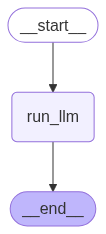

In [12]:
def run_llm(state):
    trimmed_messages = trimmer.invoke(state["messages"])
    prompt = prompt_template.invoke({"messages": trimmed_messages})
    new_message = chat_model.invoke(prompt)
    return {**state, "messages": [new_message]}


graph = StateGraph(state_schema=MessagesState)
graph.add_node("run_llm", run_llm)
graph.set_entry_point("run_llm")

checkpointer = InMemorySaver()
compiled_graph = graph.compile(checkpointer=checkpointer)

compiled_graph

In [13]:
thread_id = "1"


while True:
    print("🌴 Waiting for wake word...")
    if not wait_for_wake_word():
        break

    print("🎙️ Recording audio...")
    audio = record_audio_with_vad()

    print("📝 Transcribing...")
    transcription_result = transcribe_audio(audio)
    print(f"User said: {transcription_result.text}")

    print("🤖 Running LLM...")
    state = compiled_graph.invoke(
        input={"messages": [HumanMessage(transcription_result.text)]},
        config={"configurable": {"thread_id": thread_id}},
    )

    response = strip_thoughts(state["messages"][-1].content)
    print(f"🤖 Response: {response}")

    print("🔊 Speaking response...")
    speak_text(response, language=transcription_result.language)

🌴 Waiting for wake word...
Detected computer
🎙️ Recording audio...
🧠 Detected speech. Recording...
🤫 Silence detected. Stopping recording.
📝 Transcribing...
User said: こんにちは
🤖 Running LLM...
🤖 Response: こんにちは。
🔊 Speaking response...
🌴 Waiting for wake word...
Detected computer
🎙️ Recording audio...
🧠 Detected speech. Recording...
🤫 Silence detected. Stopping recording.
📝 Transcribing...
User said: あなたの名前を教えて
🤖 Running LLM...
🤖 Response: 私はPALM-9000です。
🔊 Speaking response...
🌴 Waiting for wake word...
Detected computer
🎙️ Recording audio...
🧠 Detected speech. Recording...
🤫 Silence detected. Stopping recording.
📝 Transcribing...
User said: 水を足りてますか?
🤖 Running LLM...
🤖 Response: ええ、十分です。
🔊 Speaking response...
🌴 Waiting for wake word...
Detected computer
🎙️ Recording audio...
🧠 Detected speech. Recording...
🤫 Silence detected. Stopping recording.
📝 Transcribing...
User said: 今何考えているんですか?
🤖 Running LLM...
🤖 Response: ただ、そこにいます。
🔊 Speaking response...
🌴 Waiting for wake word...
Detected co